1단계: 작업 환경 구성하기

먼저 필요한 디렉토리들을 생성해줍니다.

In [2]:
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

In [10]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


2단계: 데이터셋 구성하기

CIFAR-10 데이터셋을 tf.keras.datasets에서 가져와서 학습에 사용할 데이터를 준비합니다.

In [15]:
import tensorflow as tf

# CIFAR-10 데이터셋 로드
cifar10 = tf.keras.datasets.cifar10

# 데이터 로드 및 분리
(train_x, _), (test_x, _) = cifar10.load_data()

# train_x 크기 확인
print(train_x.shape)

(50000, 32, 32, 3)


데이터 전처리: 이미지를 -1, 1로 정규화합니다.

In [16]:
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

In [17]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [18]:
train_x = (train_x / 127.5) - 1

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


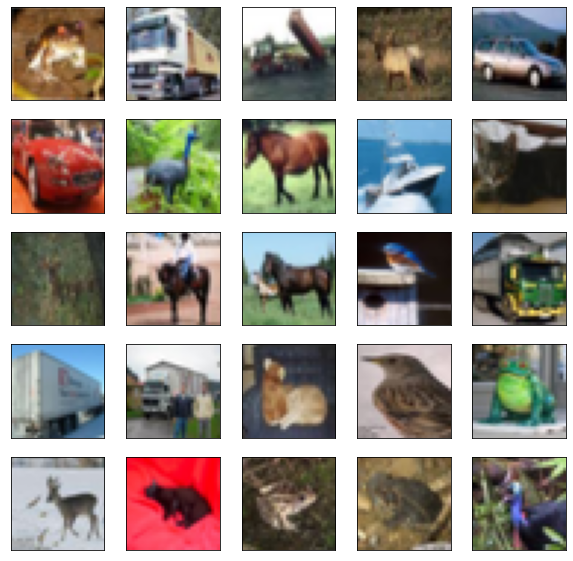

Batch shape: (256, 32, 32, 3)


In [19]:
# 학습 데이터 시각화
def visualize_data(data, num_images=25):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow((data[i] + 1) / 2)  # 정규화 해제 후 출력
    plt.show()

# 데이터 확인
visualize_data(train_x)

# 미니배치 데이터셋 구성
BATCH_SIZE = 256
BUFFER_SIZE = 60000

# tf.data.Dataset을 활용하여 데이터셋 구성
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 데이터셋 확인
for batch in train_dataset.take(1):
    print("Batch shape:", batch.shape)


3단계: 생성자 모델 구현하기

4단계: 판별자 모델 구현하기

In [30]:
from tensorflow.keras import layers, models
import tensorflow as tf

# 생성자 모델
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(8*8*256, input_dim=100))
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same', activation='tanh'))

    return model

# 판별자 모델
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))  # 32x32x3 이미지 입력
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())  # 2D 텐서를 1D로 변환
    model.add(layers.Dense(1, activation='sigmoid'))  # 확률값 출력

    return model

# 생성자 모델과 판별자 모델을 생성합니다.
generator = build_generator()
discriminator = build_discriminator()

# 랜덤 노이즈로 이미지를 생성합니다.
noise = tf.random.normal([1, 100])  # 배치 크기 1, 노이즈 벡터 크기 100
generated_image = generator(noise, training=False)  # 생성된 이미지

# 판별자가 생성된 이미지를 어떻게 판별하는지 확인합니다.
decision = discriminator(generated_image)
print(decision)


tf.Tensor([[0.4992103]], shape=(1, 1), dtype=float32)


5단계: 손실 함수와 최적화 함수 구현하기

In [31]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 옵티마이저 정의
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


6단계: 훈련과정 상세 기능 구현하기

In [41]:
@tf.function
def train_step(real_images):
    noise = tf.random.normal([64, 100])  # 배치 크기 64
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# 이미지를 저장하는 함수
import os
import numpy as np
import imageio

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    os.makedirs('generated_samples', exist_ok=True)
    for i in range(predictions.shape[0]):
        image = (predictions[i].numpy() * 127.5 + 127.5).astype(np.uint8)
        imageio.imsave(f'generated_samples/image_at_epoch_{epoch}.png', image)

# 손실 기록을 위한 리스트 초기화
gen_loss_history = []
disc_loss_history = []

# 훈련 루프 수정
def train(dataset, epochs):
    seed = tf.random.normal([16, 100])  # 고정된 seed
    for epoch in range(epochs):
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        step = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            step += 1

        # 에포크 평균 손실 기록
        gen_loss_history.append(epoch_gen_loss / step)
        disc_loss_history.append(epoch_disc_loss / step)

        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)
            print(f'Epoch {epoch+1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}')

    # 최종 손실 그래프 출력
    plot_loss_history()

# 손실 기록 그래프 함수
def plot_loss_history():
    import matplotlib.pyplot as plt

    plt.plot(gen_loss_history, label="Generator Loss")
    plt.plot(disc_loss_history, label="Discriminator Loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss History")
    plt.show()


7단계: 학습 과정 진행하기

Epoch 10, Gen Loss: 1.0529333353042603, Disc Loss: 0.8514018058776855
Epoch 20, Gen Loss: 0.9499654173851013, Disc Loss: 1.068737268447876
Epoch 30, Gen Loss: 0.9134393930435181, Disc Loss: 1.0307719707489014
Epoch 40, Gen Loss: 0.735427975654602, Disc Loss: 1.1529576778411865
Epoch 50, Gen Loss: 0.9706977009773254, Disc Loss: 1.115598440170288


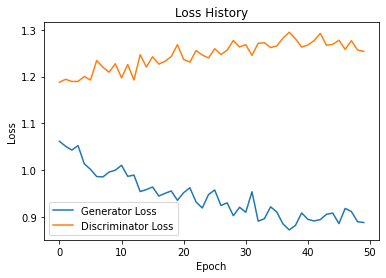

In [42]:
EPOCHS = 50
train(train_dataset, EPOCHS)


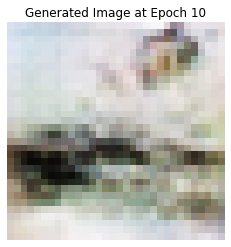

In [46]:
import matplotlib.pyplot as plt
import os
from PIL import Image

def display_generated_images(epoch):
    folder = 'generated_samples'
    filename = f'image_at_epoch_{epoch}.png'
    file_path = os.path.join(folder, filename)

    if os.path.exists(file_path):
        img = Image.open(file_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Generated Image at Epoch {epoch}")
        plt.show()
    else:
        print(f"No image found for epoch {epoch}.")

# 예시: 10번째 epoch에서 생성된 이미지 확인
display_generated_images(10)


In [44]:
# 모델 저장
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')


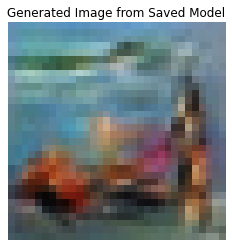

In [57]:
# 저장된 모델 불러오기
from tensorflow.keras.models import load_model

loaded_generator = load_model('generator_model.h5')

# 새로운 이미지 생성
new_noise = tf.random.normal([1, 100])  # 새로운 노이즈
new_generated_image = loaded_generator(new_noise, training=False)

# 이미지 시각화
plt.imshow((new_generated_image[0] + 1) / 2)
plt.axis('off')
plt.title("Generated Image from Saved Model")
plt.show()


In [58]:
# 평가를 위한 노이즈와 데이터 준비
test_noise = tf.random.normal([64, 100])
fake_images = generator(test_noise, training=False)
real_images = next(iter(train_dataset))  # 실제 이미지 배치

# 판별자 출력
real_output = discriminator(real_images, training=False)
fake_output = discriminator(fake_images, training=False)

print("Real Image Discriminator Output Mean:", tf.reduce_mean(real_output).numpy())
print("Fake Image Discriminator Output Mean:", tf.reduce_mean(fake_output).numpy())


Real Image Discriminator Output Mean: 0.49514192
Fake Image Discriminator Output Mean: 0.26139215


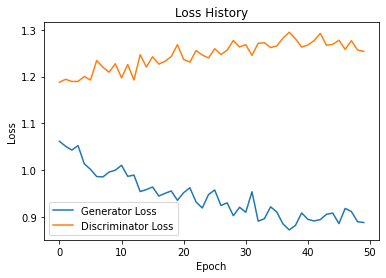

In [59]:
import matplotlib.pyplot as plt

# 예시 그래프 그리기 (loss 저장 필요)
plt.plot(gen_loss_history, label="Generator Loss")
plt.plot(disc_loss_history, label="Discriminator Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss History")
plt.show()


8단계: (optional) GAN 훈련 과정 개선하기

Epoch 1/50, Generator Loss: 2.2962493896484375, Discriminator Loss: 0.5834912657737732
Epoch 2/50, Generator Loss: 1.7690112590789795, Discriminator Loss: 0.6219702959060669
Epoch 3/50, Generator Loss: 1.5264866352081299, Discriminator Loss: 0.6056340932846069
Epoch 4/50, Generator Loss: 1.9010374546051025, Discriminator Loss: 0.513703465461731
Epoch 5/50, Generator Loss: 2.5262248516082764, Discriminator Loss: 0.6732866168022156
Epoch 6/50, Generator Loss: 2.2503280639648438, Discriminator Loss: 0.6535565853118896
Epoch 7/50, Generator Loss: 2.493365526199341, Discriminator Loss: 0.4190864562988281
Epoch 8/50, Generator Loss: 2.3830366134643555, Discriminator Loss: 0.4694192409515381
Epoch 9/50, Generator Loss: 2.3752312660217285, Discriminator Loss: 0.5210011601448059
Epoch 10/50, Generator Loss: 2.431087017059326, Discriminator Loss: 0.4931500256061554
Epoch 11/50, Generator Loss: 2.799696922302246, Discriminator Loss: 0.42189526557922363
Epoch 12/50, Generator Loss: 2.7312581539154

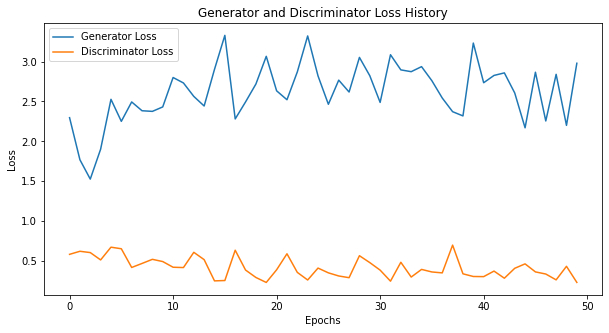

In [60]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

# 체크포인트 디렉토리 설정
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator)

# 학습률 조정된 옵티마이저
generator_optimizer = tf.keras.optimizers.Adam(1e-5)  # 생성자 학습률 감소
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)  # 디스크리미네이터 학습률 유지

# 손실 기록용 리스트 초기화
gen_loss_history = []
disc_loss_history = []

# 훈련 함수 (훈련 재개 포함)
@tf.function
def train_step(real_images):
    noise = tf.random.normal([64, 100])  # 배치 크기 64
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# 이미지 생성 및 저장 함수
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    os.makedirs('generated_samples', exist_ok=True)
    plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2)  # [-1, 1] 범위를 [0, 1]로 변환
        plt.axis('off')
    plt.savefig(f'generated_samples/image_at_epoch_{epoch:04d}.png')
    plt.close()

# 훈련 루프 (훈련 재개 포함)
def train(dataset, epochs, save_every=10):
    seed = tf.random.normal([16, 100])  # 고정된 seed
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        gen_loss_history.append(gen_loss.numpy())
        disc_loss_history.append(disc_loss.numpy())

        print(f'Epoch {epoch+1}/{epochs}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}')

        # 주기적으로 이미지 저장 및 모델 체크포인트 저장
        if (epoch + 1) % save_every == 0:
            generate_and_save_images(generator, epoch + 1, seed)
            checkpoint.save(file_prefix=checkpoint_prefix)

# 체크포인트 로드 및 훈련 재개
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest:
    checkpoint.restore(latest)
    print(f"Checkpoint restored from {latest}.")

# 훈련 재개
EPOCHS = 50
save_every = 10
train(train_dataset, EPOCHS, save_every)

# 학습 손실 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(gen_loss_history, label='Generator Loss')
plt.plot(disc_loss_history, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator and Discriminator Loss History')
plt.show()


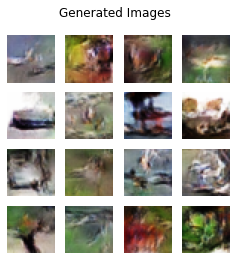

In [61]:
# 평가를 위한 새로운 노이즈로 이미지 생성
noise = tf.random.normal([16, 100])  # 16개의 샘플 생성
generated_images = generator(noise, training=False)

# 생성된 이미지 시각화
plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow((generated_images[i] + 1) / 2)  # [-1, 1] 범위를 [0, 1]로 변환
    plt.axis('off')
plt.suptitle("Generated Images")
plt.show()


In [62]:
# 평가용 노이즈 생성
noise = tf.random.normal([100, 100])  # 100개의 샘플 생성
generated_images = generator(noise, training=False)

# 실제 데이터셋에서 100개 샘플 가져오기
real_images = next(iter(train_dataset.take(1)))

# 판별자 출력 계산
real_output = discriminator(real_images, training=False)
fake_output = discriminator(generated_images, training=False)

# 평균 출력값 확인
print(f"Real Image Discriminator Output Mean: {tf.reduce_mean(real_output).numpy()}")
print(f"Fake Image Discriminator Output Mean: {tf.reduce_mean(fake_output).numpy()}")


Real Image Discriminator Output Mean: 0.49621665477752686
Fake Image Discriminator Output Mean: 0.006093306466937065


오히려 성능이 떨어짐...

In [65]:
# 체크포인트 디렉토리 설정
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator)

# 학습률 조정된 옵티마이저
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)  # 생성자 학습률 증가, beta_1을 0.5로 설정
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  # 판별자 학습률 조정

# 손실 기록용 리스트 초기화
gen_loss_history = []
disc_loss_history = []

# 훈련 함수 (훈련 재개 포함)
@tf.function
def train_step(real_images):
    noise = tf.random.normal([64, 100])  # 배치 크기 64
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# 이미지 생성 및 저장 함수
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    save_dir = 'aiffel/dcgan_newimage/generated_samples'
    os.makedirs(save_dir, exist_ok=True)
    for i in range(predictions.shape[0]):
        img_path = f'{save_dir}/image_at_epoch_{epoch:04d}.png'  # 절대 경로로 수정
        print(f"Saving image: {img_path}")
        image = (predictions[i].numpy() * 127.5 + 127.5).astype(np.uint8)
        imageio.imsave(img_path, image)
    
# GIF 생성 함수
def create_gif(epoch_start, epoch_end):
    images = []
    save_dir = 'aiffel/dcgan_newimage/generated_samples'  # 동일한 경로로 수정
    for epoch in range(epoch_start, epoch_end + 1):
        img_path = f'{save_dir}/image_at_epoch_{epoch:04d}.png'  # 절대 경로로 수정
        print(f"Checking if {img_path} exists...")
        if os.path.exists(img_path):
            print(f"Loading image: {img_path}")
            images.append(imageio.imread(img_path))

    if images:
        gif_path = 'generated_samples/animation.gif'
        imageio.mimsave(gif_path, images, duration=0.5)  # GIF를 생성
        print(f"GIF saved to {gif_path}")
    else:
        print("No images found to create GIF.")

# 훈련 루프 (훈련 재개 포함)
def train(dataset, epochs, save_every=10):
    seed = tf.random.normal([16, 100])  # 고정된 seed
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        gen_loss_history.append(gen_loss.numpy())
        disc_loss_history.append(disc_loss.numpy())

        print(f'Epoch {epoch+1}/{epochs}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}')

        # 주기적으로 이미지 저장 및 모델 체크포인트 저장
        if (epoch + 1) % save_every == 0:
            generate_and_save_images(generator, epoch + 1, seed)
            checkpoint.save(file_prefix=checkpoint_prefix)

            # GIF 생성 (10에포크마다)
            if (epoch + 1) % 10 == 0:
                create_gif(epoch - 9, epoch)  # 이전 10개의 에포크로 움짤 생성




Checkpoint restored from ./training_checkpoints/ckpt-9.
Epoch 1/50, Generator Loss: 1.0144519805908203, Discriminator Loss: 0.8612730503082275
Epoch 2/50, Generator Loss: 0.9961830377578735, Discriminator Loss: 0.8431670665740967
Epoch 3/50, Generator Loss: 0.9267559051513672, Discriminator Loss: 1.121558666229248
Epoch 4/50, Generator Loss: 0.9663747549057007, Discriminator Loss: 0.9485388398170471
Epoch 5/50, Generator Loss: 1.0655827522277832, Discriminator Loss: 1.0105441808700562
Epoch 6/50, Generator Loss: 0.9377669095993042, Discriminator Loss: 0.9535022974014282
Epoch 7/50, Generator Loss: 1.0491178035736084, Discriminator Loss: 0.9877966642379761
Epoch 8/50, Generator Loss: 1.0317389965057373, Discriminator Loss: 0.9299220442771912
Epoch 9/50, Generator Loss: 1.0433099269866943, Discriminator Loss: 0.8586199283599854
Epoch 10/50, Generator Loss: 0.9096445441246033, Discriminator Loss: 1.0910980701446533
Saving image: aiffel/dcgan_newimage/generated_samples/image_at_epoch_0010.

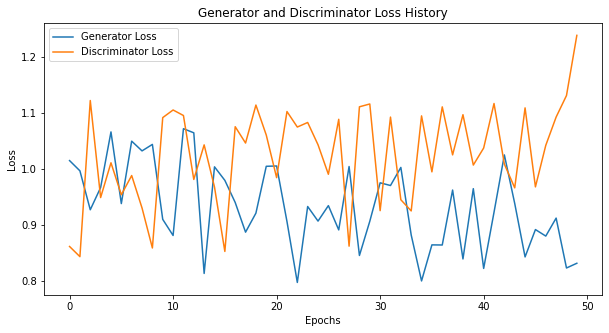

In [66]:
# 체크포인트 로드 및 훈련 재개
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest:
    checkpoint.restore(latest)
    print(f"Checkpoint restored from {latest}.")

# 훈련 재개
EPOCHS = 50
save_every = 10
train(train_dataset, EPOCHS, save_every)

# 학습 손실 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(gen_loss_history, label='Generator Loss')
plt.plot(disc_loss_history, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator and Discriminator Loss History')
plt.show()

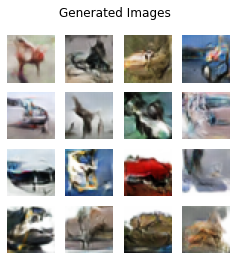

In [67]:
# 평가를 위한 새로운 노이즈로 이미지 생성
noise = tf.random.normal([16, 100])  # 16개의 샘플 생성
generated_images = generator(noise, training=False)

# 생성된 이미지 시각화
plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow((generated_images[i] + 1) / 2)  # [-1, 1] 범위를 [0, 1]로 변환
    plt.axis('off')
plt.suptitle("Generated Images")
plt.show()

In [68]:
# 평가용 노이즈 생성
noise = tf.random.normal([100, 100])  # 100개의 샘플 생성
generated_images = generator(noise, training=False)

# 실제 데이터셋에서 100개 샘플 가져오기
real_images = next(iter(train_dataset.take(1)))

# 판별자 출력 계산
real_output = discriminator(real_images, training=False)
fake_output = discriminator(generated_images, training=False)

# 평균 출력값 확인
print(f"Real Image Discriminator Output Mean: {tf.reduce_mean(real_output).numpy()}")
print(f"Fake Image Discriminator Output Mean: {tf.reduce_mean(fake_output).numpy()}")


Real Image Discriminator Output Mean: 0.35614925622940063
Fake Image Discriminator Output Mean: 0.26159489154815674


## 첫 번째 결과가 가장 좋은 이유에 대해서 분석
#### 1. 학습률 설정
첫 번째 코드에서는 생성자와 판별자의 학습률을 적절히 조정한 점이 중요합니다.
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)와 discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)로 설정된 학습률이 모델 학습에 중요한 역할을 합니다.
학습률이 너무 낮으면 모델이 충분히 학습되지 않거나 시간이 오래 걸릴 수 있습니다. 반면에 너무 높으면 최적화가 불안정해질 수 있습니다.
특히 beta_1=0.5를 사용하는 것은 GAN 훈련에서 흔히 사용되는 안정화 기술 중 하나입니다. 이는 모멘텀을 조정하여 훈련을 안정시키는 역할을 합니다.
#### 2. 훈련 손실 기록 방식
첫 번째 코드에서 epoch_gen_loss와 epoch_disc_loss를 구한 뒤 에포크 단위로 손실을 기록하고 평균을 낸 후 학습 상태를 더 명확하게 추적할 수 있습니다.
손실 기록을 훈련 루프 중간에 바로 업데이트하는 대신, 한 에포크가 끝난 후에 평균을 내는 방식은 훈련의 불안정성을 줄이고 더 정확한 학습 상태를 반영할 수 있게 해줍니다.
또한, 훈련 중에 손실 그래프를 출력하는 방식이 학습이 잘 되고 있는지 확인하는 데 도움이 됩니다.
#### 3. 이미지 저장 및 확인
첫 번째 코드에서는 이미지를 저장하는 방식이 imageio.imsave로 되어 있어 저장된 이미지 파일의 정확성이 높습니다. 저장된 이미지를 확인하면서 훈련이 잘 진행되고 있는지 시각적으로 체크할 수 있습니다.
또한, generate_and_save_images 함수가 훈련 중에 주기적으로 이미지를 저장하는 방식을 채택하여 훈련 과정에서 모델이 생성하는 이미지 품질을 쉽게 점검할 수 있습니다.
#### 4. 모델 체크포인트 저장
첫 번째 코드에서는 checkpoint.save(file_prefix=checkpoint_prefix)를 사용하여 주기적으로 체크포인트를 저장하고, 훈련 재개 시 저장된 체크포인트를 로드하여 훈련을 이어갈 수 있습니다. 이 부분은 훈련이 중간에 멈췄을 때 유용합니다.
#### 5. 훈련 재개 기능
checkpoint.restore(latest)를 사용해 훈련을 재개할 수 있는 기능이 포함되어 있어서, 훈련 중간에 중단된 경우에도 손쉽게 훈련을 이어나갈 수 있었습니다. 이 기능이 특히 중요한 이유는, GAN 훈련이 불안정할 수 있기 때문에 훈련 도중 중단되었을 때 쉽게 재개할 수 있어 안정성을 제공합니다.
### 비교:
두 번째와 세 번째 코드에서 사용된 학습률이 너무 낮거나 너무 높은 경우, 혹은 beta_1 값을 조정하지 않은 부분이 훈련의 속도나 안정성에 영향을 미칠 수 있습니다.
예를 들어, 두 번째 코드에서는 generator_optimizer = tf.keras.optimizers.Adam(1e-5)로 학습률을 너무 낮게 설정하여 훈련이 너무 느리거나 성능이 저조할 수 있습니다.
세 번째 코드에서 discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)처럼 판별자의 학습률은 적당하나 생성자 학습률을 너무 낮게 설정한 것이 문제일 수 있습니다. 이로 인해 생성자가 충분히 학습하지 못할 수 있습니다.
따라서 첫 번째 코드에서 설정된 학습률과 손실 기록 방식, 이미지 저장 및 체크포인트 기능이 훈련 성능에 긍정적인 영향을 미쳤기 때문에 가장 좋은 결과를 얻을 수 있었습니다.